# Player Follow Test

## imports

In [5]:
import os
import sys
import faiss
import pretty_midi
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from numpy.linalg import norm
from scipy.stats import entropy
from itertools import combinations


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils import basename
from src.utils.midi import transpose_midi
from src.utils.constants import NOTE_NAMES
from src.ml.specdiff.model import SpectrogramDiffusion

## setup

### parameters

In [ ]:
np.random.seed(0)

data_dir = "/media/scratch/sageev-midi/20250420-f/augmented"
test_dir = "/media/scratch/sageev-midi/teeny/ceg"
pf_augmentations = os.path.join("outputs", "augmentations")
os.makedirs(pf_augmentations, exist_ok=True)
# temporary directory for transposed files
TMP_DIR = "/home/finlay/disklavier/tests/outputs/tmp"
os.makedirs(TMP_DIR, exist_ok=True)
index_path = "/media/scratch/sageev-midi/20250420-f/specdiff.faiss"

transposition_pattern = re.compile(r"_t(\d+)s\d+\.mid$")
all_results = []

all_files = glob(os.path.join(data_dir, "*.mid"))
all_files.sort()
# base_files = glob(os.path.join(DATA_DIR, "*t00s00.mid"))
base_files = glob(os.path.join(test_dir, "*.mid"))
base_files.sort()

In [7]:
model = SpectrogramDiffusion(fix_time=False, verbose=False)
index = faiss.read_index(index_path)
print(f"index loaded with {index.ntotal} vectors of size {index.d}")
print(f"creating filename to index mapping")
filename_to_index = {name: idx for idx, name in enumerate(all_files)}
print(f"created mapping with {len(filename_to_index)} entries")
for k, v in list(filename_to_index.items())[:3]:
    print(f"\t'{k}' -> {v}")

05-06 16:14:07.108191 spcdif: initializing spectrogram diffusion model                                  ]8;id=850691;file:///home/finlay/disklavier/src/ml/specdiff/model.py\model.py]8;;\:]8;id=51128;file:///home/finlay/disklavier/src/ml/specdiff/model.py#56\56]8;;\

05-06 16:14:08.147085 spcdif: model initialization complete                                             ]8;id=356051;file:///home/finlay/disklavier/src/ml/specdiff/model.py\model.py]8;;\:]8;id=846383;file:///home/finlay/disklavier/src/ml/specdiff/model.py#87\87]8;;\

index loaded with 959232 vectors of size 768
creating filename to index mapping
created mapping with 959232 entries
	'/media/scratch/sageev-midi/20250420/augmented/20231220-080-01_0000-0006_t00s00.mid' -> 0
	'/media/scratch/sageev-midi/20250420/augmented/20231220-080-01_0000-0006_t00s01.mid' -> 1
	'/media/scratch/sageev-midi/20250420/augmented/20231220-080-01_0000-0006_t00s02.mid' -> 2


In [8]:
random_files = list(np.random.choice(all_files, size=4, replace=False))
chosen_files = []
for f in base_files:
    tmp_f = f
    if "c4" in f:
        tmp_f = random_files.pop(0)
    chosen_files.append(tmp_f)

chosen_files

['/media/scratch/sageev-midi/teeny/ceg/full_47_c2.mid',
 '/media/scratch/sageev-midi/teeny/ceg/full_47_c3.mid',
 '/media/scratch/sageev-midi/20250420/augmented/20231227-080-02_0132-0138_t02s07.mid',
 '/media/scratch/sageev-midi/teeny/ceg/half_47_c2.mid',
 '/media/scratch/sageev-midi/teeny/ceg/half_47_c3.mid',
 '/media/scratch/sageev-midi/20250420/augmented/20240402-064-04_0113-0120_t03s05.mid',
 '/media/scratch/sageev-midi/teeny/ceg/quarter_47_c2.mid',
 '/media/scratch/sageev-midi/teeny/ceg/quarter_47_c3.mid',
 '/media/scratch/sageev-midi/20250420/augmented/20240401-065-02_0296-0303_t11s02.mid',
 '/media/scratch/sageev-midi/teeny/ceg/run_47_c2.mid',
 '/media/scratch/sageev-midi/teeny/ceg/run_47_c3.mid',
 '/media/scratch/sageev-midi/20250420/augmented/20250219-066-01_0328-0335_t05s05.mid']

### selected files
its not clear from these images, but "half" and "quarter" files are composed of half and quarter notes respectively. Since i made them in ableton the note ends and starts are at the same time.

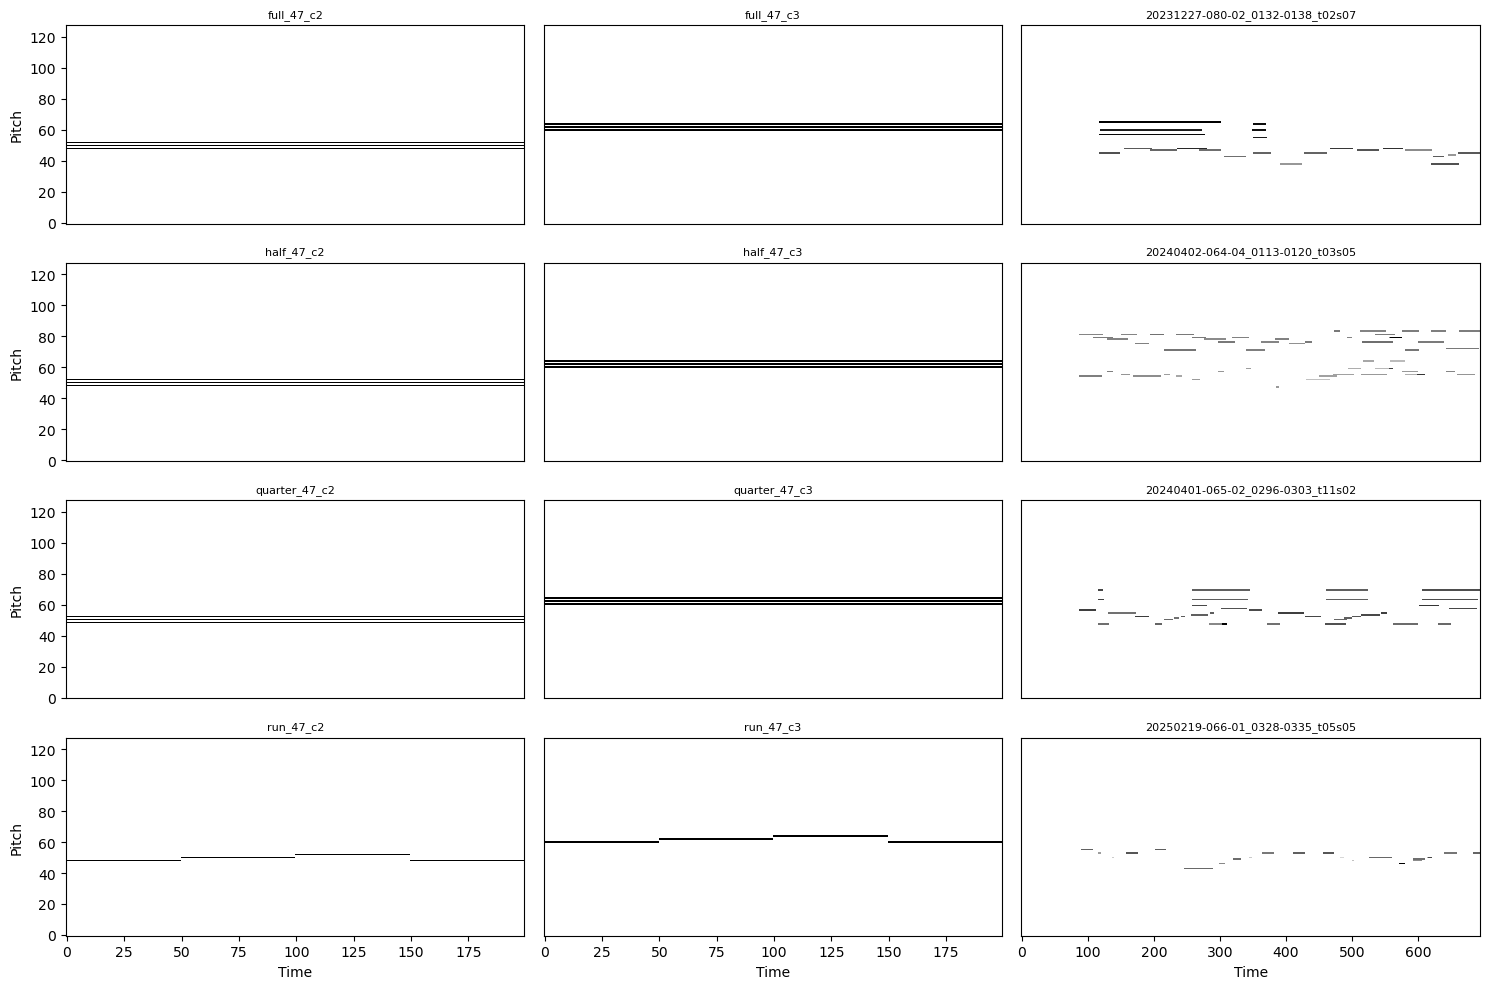

In [9]:
# Plot piano rolls of all chosen files in a 3x4 grid
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
axes = axes.flatten()

for i, file_path in enumerate(chosen_files):
    if i >= 12:  # Ensure we only plot 12 files
        break

    # Load MIDI file
    midi_data = pretty_midi.PrettyMIDI(file_path)

    # Get piano roll (fs=100 means 100 samples per second)
    piano_roll = midi_data.get_piano_roll(fs=100)

    # Plot piano roll
    im = axes[i].imshow(
        piano_roll,
        aspect="auto",
        origin="lower",
        cmap="gray_r",
        interpolation="nearest",
    )

    # Set title to the filename (basename only)
    axes[i].set_title(basename(file_path), fontsize=8)

    # Set y-axis (pitch) labels for leftmost plots only
    if i % 3 == 0:
        axes[i].set_ylabel("Pitch")
    else:
        axes[i].set_yticks([])

    # Set x-axis (time) labels for bottom plots only
    if i >= 9:
        axes[i].set_xlabel("Time")
    else:
        axes[i].set_xticks([])

plt.suptitle
plt.tight_layout()
plt.show()

## helper functions

In [17]:
def basename(filename: str) -> str:
    return os.path.splitext(os.path.basename(filename))[0]

def get_match(sys_path: str, offset: np.ndarray, mode: str = "basic") -> str:
    match mode:
        case "offset":
            sys_emb = model.embed(sys_path)
            sys_emb /= norm(sys_emb, axis=1, keepdims=True)
            sim, ind = index.search(sys_emb, 2)
            for s, i in zip(sim[0], ind[0]):
                print(f"{s} ->\t{basename(all_files[i])}")
            return all_files[ind[0][1]]
        case "basic" | _:
            sys_emb = model.embed(sys_path)
            sys_emb /= norm(sys_emb, axis=1, keepdims=True)
            sim, ind = index.search(sys_emb, 2)
            for s, i in zip(sim[0], ind[0]):
                print(f"{s} ->\t{basename(all_files[i])}")
            return all_files[ind[0][1]]


In [ ]:
sys_start = np.random.choice(all_files)
print(f"sys_start: {basename(sys_start)}")
sys_emb = model.embed(sys_start)
sys_emb /= norm(sys_emb, axis=1, keepdims=True)
sim, ind = index.search(sys_emb, 2)
for s, i in zip(sim[0], ind[0]):
    print(f"{s} ->\t{basename(all_files[i])}")

sys_start: 20240213-100-01_0293-0298_t04s05
sim: [[0.99999994 0.9960195 ]]
ind: [[331621 272197]]
0.9999999403953552 ->	20240213-100-01_0293-0298_t04s05
0.9960194826126099 ->	20240213-050-01_0586-0596_t04s05
